In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

torch.cuda.manual_seed_all(0)
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt

import time
import math

from sklearn.preprocessing import MinMaxScaler

from pathlib import Path

In [3]:
## NN training specific
EPOCHS = 10
n_intervals=10
BATCH_SIZE = 64 # training batch size
LEARNING_RATE = 0.001
epochs_list=[ (i+1)*EPOCHS//n_intervals for i in range(n_intervals) ]
print(epochs_list)
reqd_optimizer = 'Adam' # 'Adam', 'SGD'

## NN architecture specific
n_ipfields = 209 # 7: if fr+wi+sp, 209: if fr+wi+sp+prevtmps
list_of_n_hidden_neurons = [50,100, 200] ### [100], [50,100], [50,100, 200], [50,100,200,200], [50,100,200,200,205,205]
nonlin_act_func ='relu' #'relu', 'silu', 'gelu', 'Hardswish', 'mish'
op_act_func = 'sigmoid' # 'sigmoid', 'softmax'
use_bn = False # True , False
use_dropout = False

require_intermediate_ops=True
standard_regression=False # True, False

lambda_ebv=0.1
lambda_ebs=0.1

BATCH_SIZE_EVAL=128 # this is the batch size used when in eval mode

# allcolumns=['timestep', 'firing_rates', 'walk_interval', 'setpoints', 'flowpattern',
#        'q_enthalpy', 'tG_gaszone', 'tS_furnace', 'tS_obstacle',
#        'w_flux_furnace', 'w_flux_obstacle', 'nodetmp_1d_furnace',
#        'nodetmp_2d_obstacle', 'corrcoeff_b', 'Qconvi', 'extinctioncoeff_k',
#        'gasvolumes_Vi', 'QfuelQa_sum', 'surfareas_Ai', 'emissivity_epsi',
#        'convection_flux_qconvi', 'firing_rates_next', 'tG_gaszone_prev',
#        'tS_furnace_prev', 'tS_obstacle_prev']

reqd_fields_X = ['firing_rates', 'walk_interval', 'setpoints',
                 'tG_gaszone_prev', 'tS_furnace_prev', 'tS_obstacle_prev' ,
                 'corrcoeff_b', 'extinctioncoeff_k', 'gasvolumes_Vi', 'Qconvi', 'QfuelQa_sum', 'q_enthalpy',
                 'surfareas_Ai', 'emissivity_epsi' , 'convection_flux_qconvi'
                 ]
reqd_fields_y = ['tG_gaszone','tS_furnace','tS_obstacle','firing_rates_next', 'w_flux_furnace', 'w_flux_obstacle' ]

## Physical modeling related
Ng=6
n_gas_zones=24
n_fur_surf_zones=76
n_obs_surf_zones=102
sbcons= 5.6687e-08 # Stefan-Boltzmann constant

pred_normalization_type='div_by_max' #'div_by_max','sigmoid'

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

if str(device)=='cpu':
    num_workers=2 #can be kept on colab
    # num_workers=0 #on mac
else:
    num_workers=6


cpu


In [5]:
### provide path to root project directory ###

repo_path_prefix = '/content/drive/MyDrive/HZPCNet/' # if in Colab
# repo_path_prefix = '../../../../' # if in local

In [6]:
'''
Ascending SPs (normal behaviour):
default SP1,SP2,SP3,WI: 955_1220_1250_750

Type 1 (Varying SP1 only)
905_1220_1250_750.csv (Training)
915_1220_1250_750.csv (Val)
925_1220_1250_750.csv
935_1220_1250_750.csv (Training)
945_1220_1250_750.csv (Val)
965_1220_1250_750.csv
975_1220_1250_750.csv (Training)
985_1220_1250_750.csv (Val)
995_1220_1250_750.csv

Type 2 (Varying SP2 only)
955_1170_1250_750.csv (Training)
955_1180_1250_750.csv (Val)
955_1190_1250_750.csv
955_1200_1250_750.csv (Training)
955_1210_1250_750.csv (Val)
955_1230_1250_750.csv
955_1240_1250_750.csv (Training)

Type 3 (Varying SP3 only)
955_1220_1230_750.csv (Training)
955_1220_1240_750.csv (Val)
955_1220_1250_750.csv
955_1220_1260_750.csv (Training)
955_1220_1270_750.csv (Val)
955_1220_1280_750.csv
955_1220_1290_750.csv (Training)
955_1220_1300_750.csv

Type 4 (Varying WI only)
955_1220_1250_675.csv (Training)
955_1220_1250_690.csv (Val)
955_1220_1250_705.csv
955_1220_1250_720.csv (Training)
955_1220_1250_735.csv (Val)
955_1220_1250_765.csv
955_1220_1250_780.csv (Training)
955_1220_1250_795.csv (Val)
955_1220_1250_810.csv
955_1220_1250_825.csv (Training)

Arbitrary SPs (abnormal):
Type 1 (start@955-incr-dec/const)
955_1220_1200_750.csv (Training)
955_1220_1210_750.csv (Val)
955_1220_1220_750.csv
955_1250_1220_750.csv (Training)
955_1250_1220_765.csv (Val)
955_1250_1250_750.csv
955_1260_1250_750.csv (Training)
955_1270_1250_750.csv

Type 2 (start@1220-incr-dec)
1220_1250_955_750.csv (Training)
1220_1250_955_795.csv
Type 3 (start@1220-dec-inc)
1220_955_1250_750.csv (Training)
1220_955_1250_780.csv

Type 4 (start@1250-dec-inc)
1250_955_1220_750.csv (Training)
1250_955_1220_825.csv
Type 5 (start@1250-dec-dec)
1250_1220_955_750.csv (Training)
1250_1220_955_810.csv
'''

dirpath = repo_path_prefix+'input_data/data_L_1/'+'configs_csv/'
files = [f for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath, f))]
print(len(files))

trainfiles=['905_1220_1250_750', '935_1220_1250_750', '975_1220_1250_750',
'955_1170_1250_750', '955_1200_1250_750', '955_1240_1250_750',
'955_1220_1230_750', '955_1220_1260_750', '955_1220_1290_750',
'955_1220_1250_675', '955_1220_1250_720', '955_1220_1250_780', '955_1220_1250_825',
'955_1220_1200_750',  '955_1250_1220_750', '955_1260_1250_750',
'1220_1250_955_750',  '1220_955_1250_750',
'1250_955_1220_750', '1250_1220_955_750']

valfiles=['915_1220_1250_750', '945_1220_1250_750', '985_1220_1250_750',
'955_1180_1250_750', '955_1210_1250_750',
'955_1220_1240_750', '955_1220_1270_750',
'955_1220_1250_690', '955_1220_1250_735', '955_1220_1250_795',
'955_1220_1210_750', '955_1250_1220_765']

testfiles=['925_1220_1250_750', '965_1220_1250_750', '995_1220_1250_750',
'955_1190_1250_750', '955_1230_1250_750',
'955_1220_1250_750', '955_1220_1280_750', '955_1220_1300_750',
'955_1220_1250_705', '955_1220_1250_765', '955_1220_1250_810',
'955_1220_1220_750', '955_1250_1250_750', '955_1270_1250_750',
'1220_1250_955_795', '1220_955_1250_780',
'1250_955_1220_825', '1250_1220_955_810']

trainfiles=[file+'.csv' for file in trainfiles]
valfiles=[file+'.csv' for file in valfiles]
testfiles=[file+'.csv' for file in testfiles]

perfile_timesteps=1500
# for iix,file in enumerate(trainfiles):
#     print('id:',iix,file)
print('#train files: ',len(trainfiles),'#train timesteps: ',len(trainfiles)*perfile_timesteps)
# for iix,file in enumerate(valfiles):
#     print('id:',iix,file)
print('#val files: ',len(valfiles),'#val timesteps: ',len(valfiles)*perfile_timesteps)
# for iix,file in enumerate(testfiles):
#     print('id:',iix,file)
print('#test files: ',len(testfiles),'#test timesteps: ',len(testfiles)*perfile_timesteps)

50
#train files:  20 #train timesteps:  30000
#val files:  12 #val timesteps:  18000
#test files:  18 #test timesteps:  27000


In [7]:
def filepath2df(filepath):
    ## we break the time-dependent nature of the data, and cast it into a supervised learning format
    df=pd.read_csv(filepath)
    df['firing_rates_next'] = df['firing_rates'].shift(-1)

    df['tG_gaszone_prev'] = df['tG_gaszone'].shift(1)
    df['tS_furnace_prev'] = df['tS_furnace'].shift(1)
    df['tS_obstacle_prev'] = df['tS_obstacle'].shift(1)

    df = df.drop(df.tail(1).index) # Drop last row (due to firing_rates shifting)
    df = df.drop(df.head(1).index) # Drop first row (due to tG and tS shifting)

    df=df.reset_index(drop=True)
    return df

def get_field_matrix(reqfield,df):
    if reqfield!='walk_interval':
        for i in range(1,df.shape[0]):
            if i==1:
                tmp=eval(df.loc[i,reqfield])
                X=np.vstack([eval(df.loc[0,reqfield]),tmp])
            else:
                tmp=eval(df.loc[i,reqfield])
                X=np.vstack([X,tmp])
    else:
        X = df['walk_interval'].values.reshape(-1,1)
    # print(X.shape)
    # print(X)
    return X

def get_hstacked_X(df,reqd_fields):
    ind_ranges=[] #to identify/index into individual fields
    if len(reqd_fields)==1:
        X=get_field_matrix(reqd_fields[0],df)
        ind_ranges.append(X.shape[1])
    else:
        for ii in range(1,len(reqd_fields)):
            if ii==1:
                X0,X1=get_field_matrix(reqd_fields[0],df),get_field_matrix(reqd_fields[1],df)
                ind_ranges.extend([X0.shape[1],X1.shape[1]])
                X=np.hstack([X0,X1])
                del X0, X1
            else:
                Xii=get_field_matrix(reqd_fields[ii],df)
                ind_ranges.append(Xii.shape[1])
                X=np.hstack([X,Xii])
                del Xii
    return X,ind_ranges

def df_to_Xy(df,reqd_fields_X, reqd_fields_y):
    X,ind_ranges_X=get_hstacked_X(df,reqd_fields_X)
    y,ind_ranges_y=get_hstacked_X(df,reqd_fields_y)
    return X,y,ind_ranges_X,ind_ranges_y

def get_consolidated_matrix(splitfiles):
    file=splitfiles[0]
    df=filepath2df(dirpath+file)
    X,y,ind_ranges_X,ind_ranges_y = df_to_Xy(df,reqd_fields_X, reqd_fields_y)
    # print(X.shape,y.shape,ind_ranges_X,ind_ranges_y)

    for file in splitfiles[1:]:
        df=filepath2df(dirpath+file)
        X_,y_,_,_ = df_to_Xy(df,reqd_fields_X, reqd_fields_y)
        X=np.vstack([X,X_])
        y=np.vstack([y,y_])
    return X,y,ind_ranges_X,ind_ranges_y

In [8]:
npdirpath = repo_path_prefix+'input_data/data_L_1/'+'pre_saved_npfiles/'
reqdfile=npdirpath+'zonenet_npfile'+'.npz'

if Path(reqdfile).exists():
    t1=time.time()
    loaded = np.load(npdirpath+'zonenet_npfile'+'.npz')

    Xtr = loaded['Xtr']
    ytr = loaded['ytr']
    ind_ranges_X = loaded['ind_ranges_X']
    ind_ranges_y = loaded['ind_ranges_y']
    Xval = loaded['Xval']
    yval = loaded['yval']
    Xtst = loaded['Xtst']
    ytst = loaded['ytst']

    if standard_regression:
        ## standard format for baseline regression

        # reqd_fields_X = ['firing_rates', 'walk_interval', 'setpoints']
        # reqd_fields_y = ['tG_gaszone','tS_furnace','tS_obstacle','firing_rates_next']

        Xtr = loaded['Xtr'][:,:7]
        ytr = loaded['ytr'][:,:205]
        ind_ranges_X = loaded['ind_ranges_X'][:3]
        ind_ranges_y = loaded['ind_ranges_y'][:4]
        Xval = loaded['Xval'][:,:7]
        yval = loaded['yval'][:,:205]
        Xtst = loaded['Xtst'][:,:7]
        ytst = loaded['ytst'][:,:205]

    print('Time for consolidating train, val, test data: ', time.time()-t1)
    # print(np.array_equal(Xtr, loaded['Xtr'])) ## for checking if loaded array is equal to actual Xtr (if present separately)
else:
    t1=time.time()
    Xtr,ytr,ind_ranges_X,ind_ranges_y=get_consolidated_matrix(trainfiles)
    Xval,yval,_,_=get_consolidated_matrix(valfiles)
    Xtst,ytst,_,_=get_consolidated_matrix(testfiles)
    print('Time for consolidating train, val, test data: ', time.time()-t1)

    np.savez_compressed(npdirpath+'zonenet_npfile',
                    Xtr=Xtr,ytr=ytr,ind_ranges_X=ind_ranges_X,ind_ranges_y=ind_ranges_y,
                    Xval=Xval,yval=yval,Xtst=Xtst,ytst=ytst)

print(Xtr.shape,ytr.shape,Xval.shape,yval.shape,Xtst.shape,ytst.shape)

Time for consolidating train, val, test data:  15.988033056259155
(29960, 857) (29960, 383) (17976, 857) (17976, 383) (26964, 857) (26964, 383)


In [9]:
print(ind_ranges_X,sum(ind_ranges_X))
print(ind_ranges_y,sum(ind_ranges_y))

[  3   1   3  24  76 102  12   6  24  24  24  24 178 178 178] 857
[ 24  76 102   3  76 102] 383


In [10]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 3)

def list_to_individual(metrics_list, ind_ranges_y, sqrt_result_list=False):
    result_list=[]
    prev_n_ , sum_n_ = 0 , 0
    for n_ in ind_ranges_y[:-1]:
        sum_n_ += n_
        metrics_list_reqfield=metrics_list[prev_n_:sum_n_]
        prev_n_=sum_n_
        result_list.append(round(sum(metrics_list_reqfield)/len(metrics_list_reqfield),3))
    metrics_list_reqfield=metrics_list[prev_n_:]
    result_list.append(round(sum(metrics_list_reqfield)/len(metrics_list_reqfield),3))
    result_list.append(round(sum(metrics_list)/len(metrics_list),3))
    if not sqrt_result_list:
        return result_list
    else:
        return [round(math.sqrt(res_), 3) for res_ in result_list]

def print_metrics(y,y_pred_mat,ind_ranges_y):
    ## whole opvars_list = '[tG, tS_fur, tS_obs, fr_next, avg]' but we print only relevant ones using:
    opvars_list = '[tG, tS_fur, tS_obs]' ## index till [:3]
    for metric_ in metrics:
        metric_list=[]
        for jj in range(y_pred_mat.shape[1]):
            if metric_=='RMSE':
                # metric_list.append(math.sqrt(mean_squared_error(y[:,jj], y_pred_mat[:,jj])))
                metric_list.append(mean_squared_error(y[:,jj], y_pred_mat[:,jj], squared=False))
            if metric_=='MSE':
                metric_list.append(mean_squared_error(y[:,jj], y_pred_mat[:,jj]))
            if metric_=='MAE':
                metric_list.append(mean_absolute_error(y[:,jj], y_pred_mat[:,jj]))
            if metric_=='MAPE': # apply it when you don’t have values close to 0
                metric_list.append(mape(0.05+y[:,jj], 0.05+y_pred_mat[:,jj]))
        if metric_=='MAPE': # compute and print only for next firing rates
            opvars_list = '[fr_next]'
            print(metric_+'--'+opvars_list+'--',list_to_individual(metric_list,ind_ranges_y)[3])
        elif metric_!='R-MSE':
            print(metric_+'--'+opvars_list+'--',list_to_individual(metric_list,ind_ranges_y)[:3])
        else:
            sqrt_result_list=True
            print(metric_+'--'+opvars_list+'--',list_to_individual(metric_list,ind_ranges_y,sqrt_result_list)[:3])

def eval_naive_baseline(ytr, ytst,split,ind_ranges_y):
    ## naive baseline that predicts the average value for each variable
    print('Prediction on '+split+' data w/ naive baseline: ')
    ytst_pred_mat=np.tile(np.array([np.mean(ytr,axis=0)]),(ytst.shape[0],1))
    print_metrics(ytst,ytst_pred_mat,ind_ranges_y)
    # print(ytst_pred_mat.shape)
    # print('predicted temperatures:')
    # print(ytst_pred_mat)
    # print('actual temperatures:')
    # print(ytst)

def transformed2original_labels(multiple_scaled_samples, scaler_y):
    multiple_orig_samples=scaler_y.inverse_transform(multiple_scaled_samples)
    return multiple_orig_samples

In [11]:
metrics= ['RMSE', 'MSE' , 'MAE', 'MAPE']
opvars_list= '[ tG, tS_fur, tS_obs, fr_next, avg ]'
# eval_naive_baseline(ytr[:,:205], ytr[:,:205],'tr',ind_ranges_y[:4])
# eval_naive_baseline(ytr[:,:205], yval[:,:205],'val',ind_ranges_y[:4])
eval_naive_baseline(ytr[:,:205], ytst[:,:205],'val',ind_ranges_y[:4])

Prediction on val data w/ naive baseline: 
RMSE--[tG, tS_fur, tS_obs]-- [53.884, 48.134, 58.458]
MSE--[tG, tS_fur, tS_obs]-- [3437.757, 2812.317, 4649.884]
MAE--[tG, tS_fur, tS_obs]-- [39.042, 34.446, 42.271]
MAPE--[fr_next]-- 155.299


In [12]:
## Total Exchange Areas (Constant throughout)

tea_file_GG=repo_path_prefix+'input_data/GG.txt'
tea_file_SS=repo_path_prefix+'input_data/SS.txt'
tea_file_SG=repo_path_prefix+'input_data/SG.txt'
tea_file_GS=repo_path_prefix+'input_data/GS.txt'

def return_file2list(ipfilename):
    with open(ipfilename) as file_in:
        lines = []
        for line in file_in:
            lines.append(line)
    return lines


def return_list2arr(lines):
    n_xzones=int(len(lines)/Ng)
    tea_list=[]
    for i in range(0,Ng):
        all_lines=lines[i*n_xzones:(i+1)*n_xzones]
        # print(len(all_lines))
        for jj in range(1,len(all_lines)):
            if jj==1:
                prev_line,current_line= all_lines[0],all_lines[jj]
                prev_terms=[float(s) for s in prev_line.split()]
                current_terms=[float(s) for s in current_line.split()]
                # print(prev_terms,len(prev_terms))
                # print(current_terms,len(current_terms))
                tea_slice=np.vstack([np.array([prev_terms]),np.array([current_terms])])
            else:
                # print('jj=',jj)
                current_line= all_lines[jj]
                current_terms=[float(s) for s in current_line.split()]
                tea_slice=np.vstack([tea_slice,np.array([current_terms])])
        tea_list.append(tea_slice)
    return tea_list

def get_an_mat_tensor(tB_singlerow_tensor):
    tMat_tensor=torch.tile(tB_singlerow_tensor, (Ng, 1))
    # print('tMat:', tMat)
    coef_b_mat_T=coef_b_mat.T
    # print('coef_b_mat_T:',coef_b_mat_T)
    for ii in range(coef_b_mat_T.shape[1]):# Taylor series loop
        bn=coef_b_mat_T[:,[ii]]
        bn_tensor=torch.from_numpy(bn).float().to(device)
        if ii==0:
            an_mat_tensor=torch.mul(torch.tile(bn_tensor, (1, tMat_tensor.size(1))),tMat_tensor**ii)
        else:
            an_mat_tensor+=torch.mul(torch.tile(bn_tensor, (1, tMat_tensor.size(1))),tMat_tensor**ii)
    # print(an_mat_tensor.size())
    return an_mat_tensor

def get_teas2dfas_tensor(tea_AB,tB_singlerow_tensor):
    nrows=tea_AB[0].shape[0]
    ncols=tea_AB[0].shape[1]
    an_mat_tensor = get_an_mat_tensor(tB_singlerow_tensor)

    for ii in range(an_mat_tensor.size(0)):
        if ii==0:
            dfa_tensor=torch.mul( get_torch_float(tea_AB[ii]).to(device) , torch.tile(an_mat_tensor[[ii],:], (nrows, 1)) )
        else:
            dfa_tensor+=torch.mul( get_torch_float(tea_AB[ii]).to(device) , torch.tile(an_mat_tensor[[ii],:], (nrows, 1)) )
    # print(dfa,dfa.shape)
    return dfa_tensor

In [13]:
tea_GG=return_list2arr(return_file2list(tea_file_GG))
tea_SS=return_list2arr(return_file2list(tea_file_SS))
tea_SG=return_list2arr(return_file2list(tea_file_SG))
tea_GS=return_list2arr(return_file2list(tea_file_GS))
print(tea_GG[0].shape)

(24, 24)


In [14]:
class MinMaxScalerVectorized_pt(object): ## vectorized pytorch equivalent of sklearn's MinMaxScaler
    """MinMax Scaler

    Transforms each channel to the range [a, b].

    Parameters/ Input
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, tensor):
        """Fit features

        Parameters/ Input
        ----------
        tensor: torch.Size([n, d])
        OR
        tensor: tuple, list of features, which can be stacked together using tensor = torch.stack(tensor)

        Returns/ Ouput
        ----------
        scaled tensor optensor :torch.Size([n, d])

        The transformation is given by:

        Logic Used:
        ----------
        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        X_scaled = X_std * (max - min) + min
        where min, max = feature_range.

        """

        # Feature range
        range_min, range_max = self.feature_range

        max_along_dims, min_along_dims = tensor.max(dim=0, keepdim=True)[0] , tensor.min(dim=0, keepdim=True)[0]
        dist = max_along_dims - min_along_dims
        # [0] provides max values in each column, [1] provides corresponding indices

        ## dist is going to be the denominator, and for avoiding div by 0, set those 0 values in denominator to 1
        dist[dist == 0.0] = 1.0
        scale = 1.0 / dist

        # # avoid following two inplace operations for autograd to work well
        # tensor.mul_(scale).sub_(tensor.min(dim=0, keepdim=True)[0])
        # tensor.mul_(b - a).add_(a)

        optensor=(range_max - range_min)*scale*(tensor-min_along_dims)+range_min

        return optensor,min_along_dims,dist## NOTE: everything is a tensor

def inverse_transform_Vectorized_pt(scaledtensor,range,min_along_dims,dist):
    range_min,range_max=range
    origtensor = min_along_dims+dist*(scaledtensor-range_min)/(range_max - range_min)
    return origtensor

def get_torch_float(X):
    return torch.from_numpy(X).float()


In [15]:
scaler_x = MinMaxScaler(feature_range=(0, 1)) # converting b/w 0 and 1
Xtr_scaled = scaler_x.fit_transform(Xtr[:,:n_ipfields])
Xval_scaled = scaler_x.transform(Xval[:,:n_ipfields])
Xtst_scaled = scaler_x.transform(Xtst[:,:n_ipfields])

scaler_y = MinMaxScaler(feature_range=(0, 1)) # converting b/w 0 and 1
ytr_scaled = scaler_y.fit_transform(ytr[:,:205])

# ## Tensor/PyTorch based minmaxscaler and inverse_transform
scaler_y_pt = MinMaxScalerVectorized_pt(feature_range=(0, 1))
# ytr_scaled_pt,ytr_min_along_dims,ytr_dist = scaler_y_pt(get_torch_float(ytr[:,:205]))
_,ytr_min_along_dims,ytr_dist = scaler_y_pt(get_torch_float(ytr[:,:205]))
# print(ytr_min_along_dims.size(),ytr_dist.size())

# startid_row,endid_row=0,3
# startid_col,endid_col=0,7
# print('pt reconstructed orginal \n',inverse_transform_Vectorized_pt(ytr_scaled_pt[startid_row:endid_row,startid_col:endid_col],(0,1),ytr_min_along_dims[[0],startid_col:endid_col],ytr_dist[[0],startid_col:endid_col]))
# print('Original \n',get_torch_float(ytr[startid_row:endid_row,startid_col:endid_col]))

##########################################################################################
# scaler_x_pt = MinMaxScalerVectorized_pt(feature_range=(0, 1))
# Xtr_scaled_pt,Xtr_min_along_dims,Xtr_dist = scaler_x_pt(get_torch_float(Xtr[:,:7]))

# startid,endid=0,5
# ## original tensor
# print('Original:',get_torch_float(Xtr[startid:endid,:7]))
# ## sklearn based scaled tensor
# print('sklearn based scaled',get_torch_float(Xtr_scaled[startid:endid,:7]))
# ## using pytorch based scaled tensor
# print('pt based scaled',Xtr_scaled_pt[startid:endid,:7])

# print('sklearn reconstructed orginal',scaler_x.inverse_transform(Xtr_scaled[startid:endid,:7]))
# print('pt reconstructed orginal',inverse_transform_Vectorized_pt(Xtr_scaled_pt[startid:endid,:7],(0,1),Xtr_min_along_dims,Xtr_dist))


In [16]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

def get_regression_dataset(X,y):
    return RegressionDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())



In [17]:
train_dataset = get_regression_dataset(Xtr_scaled,ytr_scaled)
val_dataset = get_regression_dataset(Xval_scaled,yval[:,:205])
test_dataset = get_regression_dataset(Xtst_scaled,ytst[:,:205])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers = num_workers, shuffle=True, drop_last=True)
train_loader_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE_EVAL, num_workers = num_workers, shuffle=False, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_EVAL, num_workers = num_workers, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_EVAL, num_workers = num_workers, shuffle=False, drop_last=False)

In [18]:
def extract_reqfieldmat(Xtr,ind_ranges_X,index_of_field):
    startid = sum(ind_ranges_X[:index_of_field])
    endid = ind_ranges_X[index_of_field]
    X_=Xtr[ :, startid:startid+endid ]
    print(X_.shape)
    print(X_[0,:1]) # simply print first value in the first row
    return X_

## For EBV
X_tG_gaszone_prev=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('tG_gaszone_prev'))
X_tS_furnace_prev=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('tS_furnace_prev'))
X_tS_obstacle_prev=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('tS_obstacle_prev'))

#constant terms (single row matrices)
X_corrcoeff_b=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('corrcoeff_b'))[[0],:]
X_extinctioncoeff_k=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('extinctioncoeff_k'))[[0],:]
X_gasvolumes_Vi=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('gasvolumes_Vi'))[[0],:]
coef_b_mat= np.vstack([X_corrcoeff_b[[0],:int(X_corrcoeff_b.shape[1]/2)], X_corrcoeff_b[[0],int(X_corrcoeff_b.shape[1]/2):] ])
coef_k_mat=X_extinctioncoeff_k[[0],:]
del X_corrcoeff_b, X_extinctioncoeff_k
# print(coef_b_mat, coef_b_mat.shape)
# print(coef_k_mat, coef_k_mat.shape)
# print(X_gasvolumes_Vi, X_gasvolumes_Vi.shape)

X_Qconvi=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('Qconvi'))
X_QfuelQa_sum=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('QfuelQa_sum'))
X_q_enthalpy=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('q_enthalpy'))
X_hg=-X_Qconvi+X_QfuelQa_sum+X_q_enthalpy
print('X_hg.shape',X_hg.shape)

## For EBS
X_convection_flux_qconvi=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('convection_flux_qconvi'))
#constant terms (single row matrices)
X_surfareas_Ai=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('surfareas_Ai'))[[0],:]
X_emissivity_epsi=extract_reqfieldmat(Xtr,ind_ranges_X,reqd_fields_X.index('emissivity_epsi'))[[0],:]
# print(X_surfareas_Ai, X_surfareas_Ai.shape)
# print(X_emissivity_epsi, X_emissivity_epsi.shape)

X_w_flux_furnace=extract_reqfieldmat(ytr,ind_ranges_y,reqd_fields_y.index('w_flux_furnace'))
X_w_flux_obstacle=extract_reqfieldmat(ytr,ind_ranges_y,reqd_fields_y.index('w_flux_obstacle'))

X_hs=X_surfareas_Ai*X_convection_flux_qconvi-np.hstack([X_w_flux_furnace,X_w_flux_obstacle])
print('X_hs.shape',X_hs.shape)

(29960, 24)
[1230.741]
(29960, 76)
[898.918]
(29960, 102)
[272.753]
(29960, 12)
[0.717]
(29960, 6)
[0.035]
(29960, 24)
[0.61]
(29960, 24)
[103040.797]
(29960, 24)
[0.]
(29960, 24)
[325971.875]
X_hg.shape (29960, 24)
(29960, 178)
[1227.219]
(29960, 178)
[0.325]
(29960, 178)
[0.9]
(29960, 76)
[1227.219]
(29960, 102)
[36031.]
X_hs.shape (29960, 178)


In [19]:
Vi_current_tensor= get_torch_float(X_gasvolumes_Vi).to(device)
coef_k_mat_T_tensor= get_torch_float(coef_k_mat.T).to(device)
Ai_current_tensor = get_torch_float(X_surfareas_Ai).to(device)
epsi_current_tensor = get_torch_float(X_emissivity_epsi).to(device)

def to_1xd_tensor(single_tensor):
    return torch.reshape(single_tensor, (1, single_tensor.size(0)))

def get_dfa_AB_tensor_all(tea_AB,X_tB_prev):
    batch_list=list(X_tB_prev) # X_tB_prev: a torch.Size([N, d]) tensor
    batch_list_updated = list(map(lambda tB_prev_single:
                                  get_teas2dfas_tensor(
                                      tea_AB,to_1xd_tensor(tB_prev_single)
                                      ),
                                  batch_list))
    dfa_AB_tensor_all = torch.stack([sub_list for sub_list in batch_list_updated], dim=0)
    dfa_AB_tensor_all = torch.squeeze(dfa_AB_tensor_all, 1)
    return dfa_AB_tensor_all

def get_single_instance_sgarr(tea_GS,tS_prev_single):
    dfa_GS_tensor=get_teas2dfas_tensor(tea_GS,tS_prev_single)
    sgarr_tensor=torch.sum(torch.mul( dfa_GS_tensor , sbcons*torch.tile(tS_prev_single**4, (dfa_GS_tensor.size(0), 1)) ),1, keepdim=True).T
    return sgarr_tensor

def get_sgarr_plus_hg_all(X_hg,tea_AB,X_tB_prev):
    hg_list=list(X_hg)
    batch_list=list(X_tB_prev) # X_tB_prev: a torch.Size([N, d]) tensor
    batch_list_updated = list(map(lambda hg_tensor, tB_prev_single:
                                  to_1xd_tensor(hg_tensor)+
                                  get_single_instance_sgarr(
                                      tea_AB , to_1xd_tensor(tB_prev_single)
                                      ),
                                  hg_list, batch_list))
    # list(map(lambda x, y: x+ ' ' +y, listA, listB))

    sgarr_plus_hg_all = torch.stack([sub_list for sub_list in batch_list_updated], dim=0)
    sgarr_plus_hg_all = torch.squeeze(sgarr_plus_hg_all, 1)
    return sgarr_plus_hg_all

def get_single_instance_gsarr(tea_SG,tG_prev_single):
    dfa_SG_tensor=get_teas2dfas_tensor(tea_SG,tG_prev_single)
    gsarr_tensor=torch.sum(torch.mul( dfa_SG_tensor , sbcons*torch.tile(tG_prev_single**4, (dfa_SG_tensor.size(0), 1)) ),1, keepdim=True).T
    return gsarr_tensor

def get_gsarr_plus_hs_all(X_hs,tea_AB,X_tB_prev):
    hs_list=list(X_hs)
    batch_list=list(X_tB_prev) # X_tB_prev: a torch.Size([N, d]) tensor
    batch_list_updated = list(map(lambda hs_tensor, tB_prev_single:
                                  to_1xd_tensor(hs_tensor)+
                                  get_single_instance_gsarr(
                                      tea_AB , to_1xd_tensor(tB_prev_single)
                                      ),
                                  hs_list, batch_list))
    # list(map(lambda x, y: x+ ' ' +y, listA, listB))

    gsarr_plus_hs_all = torch.stack([sub_list for sub_list in batch_list_updated], dim=0)
    gsarr_plus_hs_all = torch.squeeze(gsarr_plus_hs_all, 1)
    return gsarr_plus_hs_all

def get_pb_ebv_pred_instance(sgarr_plus_hg_tensor,dfa_GG_tensor,tG_single_pred):
    startid_col,endid_col=0,n_gas_zones

    tG_current_tensor = inverse_transform_Vectorized_pt(tG_single_pred,(0,1),ytr_min_along_dims[[0],startid_col:endid_col].to(device),ytr_dist[[0],startid_col:endid_col].to(device))

    ggarr_tensor=torch.sum(torch.mul( dfa_GG_tensor , sbcons*torch.tile(tG_current_tensor**4, (dfa_GG_tensor.size(0), 1)) ),1, keepdim=True).T

    an_mat_G_tensor=get_an_mat_tensor(tG_current_tensor)

    tmpmat2=sbcons*torch.mul( torch.tile( Vi_current_tensor ,(an_mat_G_tensor.size(0),1) ) , torch.tile(tG_current_tensor**4, (an_mat_G_tensor.size(0), 1)) )
    tmpmat1=torch.mul( an_mat_G_tensor , torch.tile(coef_k_mat_T_tensor, (1,an_mat_G_tensor.size(1))) )
    gleave_tensor=torch.sum(torch.mul(tmpmat1,tmpmat2),0,keepdim=True)

    pb_ebv_pred_instance= torch.abs(ggarr_tensor+sgarr_plus_hg_tensor-4*gleave_tensor)
    pb_ebv_pred_instance/=pb_ebv_pred_instance.max(dim=1, keepdim=True)[0]
    # preferred because we don't want to "force" wrong prediction to 0, unless it actually is

    return pb_ebv_pred_instance

def get_pb_ebv_pred(sgarr_plus_hg_tensor_batch,dfa_GG_tensor_batch,y_train_pred_only_tG):
    sgarr_hg_list=list(sgarr_plus_hg_tensor_batch)
    dfa_GG_list=list(dfa_GG_tensor_batch)
    tG_pred_list=list(y_train_pred_only_tG)

    batch_list_updated = list(map(lambda sgarr_plus_hg_tensor,dfa_GG_tensor,tG_single_pred:
                                  get_pb_ebv_pred_instance(
                                      to_1xd_tensor(sgarr_plus_hg_tensor), dfa_GG_tensor , to_1xd_tensor(tG_single_pred)
                                      ),
                                  sgarr_hg_list, dfa_GG_list, tG_pred_list))
    # list(map(lambda x, y: x+ ' ' +y, listA, listB))

    pb_ebv_pred = torch.stack([sub_list for sub_list in batch_list_updated], dim=0)
    pb_ebv_pred = torch.squeeze(pb_ebv_pred, 1)
    return pb_ebv_pred

def get_pb_ebs_pred_instance(gsarr_plus_hs_tensor,dfa_SS_tensor,tS_single_pred):
    startid_col,endid_col=n_gas_zones,n_gas_zones+n_fur_surf_zones+n_obs_surf_zones
    tS_current_tensor = inverse_transform_Vectorized_pt(tS_single_pred,(0,1),ytr_min_along_dims[[0],startid_col:endid_col].to(device),ytr_dist[[0],startid_col:endid_col].to(device))

    ssarr_tensor=torch.sum(torch.mul( dfa_SS_tensor , sbcons*torch.tile(tS_current_tensor**4, (dfa_SS_tensor.size(0), 1)) ),1, keepdim=True).T

    tmpmat1=sbcons*torch.mul( Ai_current_tensor , epsi_current_tensor )
    sleave_tensor=torch.mul(tmpmat1,tS_current_tensor)

    pb_ebs_pred_instance= torch.abs(ssarr_tensor+gsarr_plus_hs_tensor-sleave_tensor)
    pb_ebs_pred_instance/=pb_ebs_pred_instance.max(dim=1, keepdim=True)[0]
    # preferred because we don't want to "force" wrong prediction to 0, unless it actually is

    return pb_ebs_pred_instance

def get_pb_ebs_pred(gsarr_plus_hs_tensor_batch,dfa_SS_tensor_batch,y_train_pred_only_tS):
    gsarr_hs_list=list(gsarr_plus_hs_tensor_batch)
    dfa_SS_list=list(dfa_SS_tensor_batch)
    tS_pred_list=list(y_train_pred_only_tS)

    batch_list_updated = list(map(lambda gsarr_plus_hs_tensor,dfa_SS_tensor,tS_single_pred:
                                  get_pb_ebs_pred_instance(
                                      to_1xd_tensor(gsarr_plus_hs_tensor), dfa_SS_tensor , to_1xd_tensor(tS_single_pred)
                                      ),
                                  gsarr_hs_list, dfa_SS_list, tS_pred_list))
    # list(map(lambda x, y: x+ ' ' +y, listA, listB))

    pb_ebs_pred = torch.stack([sub_list for sub_list in batch_list_updated], dim=0)
    pb_ebs_pred = torch.squeeze(pb_ebs_pred, 1)
    return pb_ebs_pred


In [20]:
# For EBV
t1=time.time()
# torch.Size([29960, 24, 24])
dfa_GG_tensor_all = get_dfa_AB_tensor_all(tea_GG,get_torch_float(X_tG_gaszone_prev).to(device))
print('Time elapsed for dfa_GG_tensor_all: ',time.time()-t1)

t1=time.time()
# torch.Size([29960, 24])
sgarr_plus_hg_all = get_sgarr_plus_hg_all(get_torch_float(X_hg).to(device), tea_GS, torch.hstack(( get_torch_float(X_tS_furnace_prev), get_torch_float(X_tS_obstacle_prev) )).to(device)) # torch.Size([29960, 24, 24])
print('Time elapsed for sgarr_plus_hg_all: ',time.time()-t1)

# For EBS
t1=time.time()
# torch.Size([29960, 178, 178])
dfa_SS_tensor_all = get_dfa_AB_tensor_all(tea_SS,get_torch_float(np.hstack([X_tS_furnace_prev,X_tS_obstacle_prev])).to(device))
print('Time elapsed for dfa_SS_tensor_all: ',time.time()-t1)

t1=time.time()
# torch.Size([29960, 178])
gsarr_plus_hs_all = get_gsarr_plus_hs_all(get_torch_float(X_hs).to(device), tea_SG, get_torch_float(X_tG_gaszone_prev).to(device)) # torch.Size([29960, 24, 24])
print('Time elapsed for gsarr_plus_hs_all: ',time.time()-t1)

Time elapsed for dfa_GG_tensor_all:  22.518588066101074
Time elapsed for sgarr_plus_hg_all:  19.393176555633545
Time elapsed for dfa_SS_tensor_all:  38.23567032814026
Time elapsed for gsarr_plus_hs_all:  19.246869564056396


In [21]:
print(dfa_GG_tensor_all.size())
print(sgarr_plus_hg_all.size())
# print(sgarr_plus_hg_all[:2,:])
print(dfa_SS_tensor_all.size())
print(gsarr_plus_hs_all.size())
# print(gsarr_plus_hs_all[:2,:])

torch.Size([29960, 24, 24])
torch.Size([29960, 24])
torch.Size([29960, 178, 178])
torch.Size([29960, 178])


In [22]:
# [  3   1   3  24  76 102  12   6  24  24  24  24 178 178 178] 857 x
# [ 24  76 102   3  76 102] 383 y
# reqd_fields_X = ['firing_rates', 'walk_interval', 'setpoints',
#                  'tG_gaszone_prev', 'tS_furnace_prev', 'tS_obstacle_prev' ,
#                  'corrcoeff_b', 'extinctioncoeff_k', 'gasvolumes_Vi', 'Qconvi', 'QfuelQa_sum', 'q_enthalpy',
#                  'surfareas_Ai', 'emissivity_epsi' , 'convection_flux_qconvi'
#                  ]
# reqd_fields_y = ['tG_gaszone','tS_furnace','tS_obstacle','firing_rates_next', 'w_flux_furnace', 'w_flux_obstacle' ]

class RegressionDataset_EBVS(Dataset):
    def __init__(self, Xtr_scaled,ytr_scaled,
                 dfa_GG_tensor_all,sgarr_plus_hg_all,
                 dfa_SS_tensor_all,gsarr_plus_hs_all):
        self.Xtr_scaled =  get_torch_float(Xtr_scaled)
        self.ytr_scaled =  get_torch_float(ytr_scaled)
        self.dfa_GG_tensor_all = dfa_GG_tensor_all # already  tensor
        self.sgarr_plus_hg_all = sgarr_plus_hg_all
        self.dfa_SS_tensor_all = dfa_SS_tensor_all # already  tensor
        self.gsarr_plus_hs_all = gsarr_plus_hs_all

    def __getitem__(self, index):
        # dictionary of auxiliary variables
        auxvars_dict = {'dfa_GG_tensor':dfa_GG_tensor_all[index],
                        'sgarr_plus_hg': sgarr_plus_hg_all[index],
                        'dfa_SS_tensor':dfa_SS_tensor_all[index],
                        'gsarr_plus_hs': gsarr_plus_hs_all[index]
                 }
        return self.Xtr_scaled[index], self.ytr_scaled[index], auxvars_dict

    def __len__ (self):
        return len(self.Xtr_scaled)

In [23]:
train_dataset_EBVS = RegressionDataset_EBVS(Xtr_scaled,ytr_scaled,
                                            dfa_GG_tensor_all,sgarr_plus_hg_all,
                                            dfa_SS_tensor_all,gsarr_plus_hs_all)
train_loader_EBVS = DataLoader(dataset=train_dataset_EBVS, batch_size=BATCH_SIZE, num_workers = num_workers, shuffle=True, drop_last=True)

In [24]:
class MultipleRegression(nn.Module):
    ### Hard-coded
    # def __init__(self, num_features,num_outputs):
    #     super(MultipleRegression, self).__init__()

    #     self.layer_1 = nn.Linear(num_features, 50)
    #     # self.bn1 = nn.BatchNorm1d(50)
    #     self.layer_2 = nn.Linear(50, 100)
    #     # self.bn2 = nn.BatchNorm1d(100)
    #     self.layer_3 = nn.Linear(100, 200)
    #     self.layer_out = nn.Linear(200, num_outputs)

    #     self.relu = nn.ReLU()
    #     self.sigmoid = nn.Sigmoid()
    #     # self.silu = nn.SiLU()
    #     # self.gelu = nn.GELU()
    #     # self.Hardswish = nn.Hardswish()
    #     # self.mish = nn.Mish()
    #     # self.dropout = nn.Dropout(0.2)

    # def forward(self, inputs):
    #     x = self.relu(self.layer_1(inputs))
    #     # x = self.gelu(self.bn1(self.layer_1(inputs)))
    #     # x = self.dropout(x)
    #     x = self.relu(self.layer_2(x))
    #     # x = self.gelu(self.bn2(self.layer_2(x)))
    #     # x = self.dropout(x)
    #     x = self.relu(self.layer_3(x))
    #     x = self.sigmoid(self.layer_out(x))
    #     return (x)

    ### Automated
    def __init__(self, input_dim, output_dim, hidden_dims, nonlin_act_func, op_act_func, use_bn=False, use_dropout=False):
        super(MultipleRegression, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        current_dim = input_dim
        self.layers = nn.ModuleList()
        self.bnlayers = nn.ModuleList()
        self.dropoutlayers = nn.ModuleList()
        for hdim in hidden_dims:
            self.layers.append(nn.Linear(current_dim, hdim))
            if use_bn:
                self.bnlayers.append(nn.BatchNorm1d(hdim))
            else:
                self.bnlayers.append(nn.Identity())
            if use_dropout:
                self.dropoutlayers.append(nn.Dropout(0.2))
            else:
                self.dropoutlayers.append(nn.Identity())
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, output_dim))

        if nonlin_act_func=='relu':
            self.actfunc = nn.ReLU()
        if nonlin_act_func=='silu':
            self.actfunc = nn.SiLU()
        if nonlin_act_func=='gelu':
            self.actfunc = nn.GELU()
        if nonlin_act_func=='Hardswish':
            self.actfunc = nn.Hardswish()
        if nonlin_act_func=='mish':
            self.actfunc = nn.Mish()
        if op_act_func=='sigmoid':
            self.opactfunc = nn.Sigmoid()
        if op_act_func=='softmax':
            self.opactfunc = nn.Softmax()

    def forward(self, x):
        for idx, layer in enumerate(self.layers[:-1]):
            x = self.dropoutlayers[idx](self.actfunc(self.bnlayers[idx](layer(x))))
        out = self.opactfunc(self.layers[-1](x))
        return out

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size_list, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size_list = hidden_size_list
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size_list[0], num_layers, batch_first=True)
        #self.fc1 = nn.Linear(hidden_size_list[0], hidden_size_list[1])
        #self.fc2 = nn.Linear(hidden_size_list[1], hidden_size_list[2])
        self.fc = nn.Linear(hidden_size_list[0], output_size)
        #self.relu = nn.ReLU() # Add this line
        self.sigmoid = nn.Sigmoid() # Add this line

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size_list[0]).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size_list[0]).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        lstm_op_needed=out[:, -1, :]
        #out = self.fc(self.relu(self.fc2(self.relu(self.fc1(lstm_op_needed)))))
        out = self.fc(lstm_op_needed)
        out = self.sigmoid(out) # Add this line
        return out

In [25]:
# model = MultipleRegression(NUM_FEATURES,NUM_OUTPUTS) ##using hard-coded format
# model = MultipleRegression(Xtr_scaled.shape[1], ytr_scaled.shape[1], list_of_n_hidden_neurons,
#                            nonlin_act_func=nonlin_act_func, op_act_func=op_act_func,
#                            use_bn=use_bn, use_dropout=use_dropout) ##using automated format

model = LSTMRegressor(input_size=Xtr_scaled.shape[1], hidden_size_list=[100], num_layers = 3, output_size = ytr_scaled.shape[1])

model.to(device)

# print(model)

LSTMRegressor(
  (lstm): LSTM(209, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=205, bias=True)
  (sigmoid): Sigmoid()
)

In [26]:
criterion = nn.MSELoss()
if reqd_optimizer=='Adam':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
if reqd_optimizer=='SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [27]:
loss_stats = {
    'train': [],
    'train regtms': [],
    'train ebv': [],
    'train ebs': []
    # "val": []
}

In [28]:
def evaluation_module(split,train_loader_eval,val_loader,test_loader,ytr,yval,ytst,scaler_y,ind_ranges_y):
    print('split', split)
    if split=='tr':
        data_loader=train_loader_eval
        y=transformed2original_labels(ytr,scaler_y)
    if split=='val':
        data_loader=val_loader
        y=yval
    if split=='tst':
        data_loader=test_loader
        y=ytst
    with torch.no_grad():
        model.eval()
        for (batch_idx, sample_batched) in enumerate(data_loader):
            X_batch = sample_batched[0].to(device) #sample_batched[0]:data, sample_batched[1]:labels
            y_test_pred = model(X_batch).cpu().data
            # print('y_test_pred:', y_test_pred.size())
            if batch_idx!=0:
                ytst_pred_mat=torch.cat((ytst_pred_mat, y_test_pred), 0)
            else:
                ytst_pred_mat=y_test_pred
    ytst_pred_mat = ytst_pred_mat.numpy()
    print('ytst_pred_mat:', ytst_pred_mat.shape)
    print('Prediction on '+split+' data: ')
    print_metrics(y,transformed2original_labels(ytst_pred_mat,scaler_y),ind_ranges_y)
    print(y.shape,ytst_pred_mat.shape)

def eval_on_req_splits(req_splits,train_loader_eval,val_loader,test_loader,ytr,yval,ytst,scaler_y,ind_ranges_y):
    ## ['tr', 'val', 'tst']
    for split in req_splits:
        evaluation_module(split,train_loader_eval,val_loader,test_loader,ytr,yval,ytst,scaler_y,ind_ranges_y)

In [29]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_loss_regtmps = 0
    train_epoch_loss_ebv = 0
    train_epoch_loss_ebs = 0

    model.train()

    for (batch_idx, sample_batched) in enumerate(train_loader_EBVS):

        X_train_batch = sample_batched[0].to(device) #sample_batched[0]:data, sample_batched[1]:labels, sample_batched[2]:auxvars
        y_train_batch = sample_batched[1].to(device)

        auxvars_dict_batch = sample_batched[2]
        dfa_GG_tensor_batch = auxvars_dict_batch['dfa_GG_tensor'].to(device)
        sgarr_plus_hg_tensor_batch = auxvars_dict_batch['sgarr_plus_hg'].to(device)

        dfa_SS_tensor_batch = auxvars_dict_batch['dfa_SS_tensor'].to(device)
        gsarr_plus_hs_tensor_batch = auxvars_dict_batch['gsarr_plus_hs'].to(device)

        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)
        tr_loss_regtmps = criterion(y_train_pred, y_train_batch)

        ## EBV terms
        pb_ebv_pred = get_pb_ebv_pred(sgarr_plus_hg_tensor_batch,dfa_GG_tensor_batch,y_train_pred[:,:n_gas_zones])
        pb_ebv_actual = torch.zeros(pb_ebv_pred.size()).to(device)

        ## EBS terms
        pb_ebs_pred = get_pb_ebs_pred(gsarr_plus_hs_tensor_batch,dfa_SS_tensor_batch,y_train_pred[:,n_gas_zones:n_gas_zones+n_fur_surf_zones+n_obs_surf_zones])
        pb_ebs_actual = torch.zeros(pb_ebs_pred.size()).to(device)

#         if e==1 and batch_idx==0:
#             print('y_train_pred ',y_train_pred.size(),y_train_pred.requires_grad, y_train_pred)
#             print('y_train_batch ',y_train_batch.size(),y_train_batch.requires_grad, y_train_batch)
#             print('pb_ebv_pred ',pb_ebv_pred.size(),pb_ebv_pred.requires_grad, pb_ebv_pred)
#             print('pb_ebv_actual ',pb_ebv_actual.size(),pb_ebv_actual.requires_grad, pb_ebv_actual)
#             print('pb_ebs_pred ',pb_ebs_pred.size(),pb_ebs_pred.requires_grad, pb_ebs_pred)
#             print('pb_ebs_actual ',pb_ebs_actual.size(),pb_ebs_actual.requires_grad, pb_ebs_actual)

        tr_loss_ebv = criterion(pb_ebv_pred, pb_ebv_actual) / y_train_pred.size(0)
        tr_loss_ebs = criterion(pb_ebs_pred, pb_ebs_actual) / y_train_pred.size(0)

        batch_loss=tr_loss_regtmps+lambda_ebv*tr_loss_ebv+lambda_ebs*tr_loss_ebs

        batch_loss.backward()
        optimizer.step()

        train_epoch_loss += batch_loss.item()
        train_epoch_loss_regtmps += tr_loss_regtmps.item()
        train_epoch_loss_ebv += tr_loss_ebv.item()
        train_epoch_loss_ebs += tr_loss_ebs.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['train regtms'].append(train_epoch_loss_regtmps/len(train_loader))
    loss_stats['train ebv'].append(train_epoch_loss_ebv/len(train_loader))
    loss_stats['train ebs'].append(train_epoch_loss_ebs/len(train_loader))

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Loss regtmps: {train_epoch_loss_regtmps/len(train_loader):.5f} | Train Loss ebv: {train_epoch_loss_ebv/len(train_loader):.10f} | Train Loss ebs: {train_epoch_loss_ebs/len(train_loader):.10f}')

#     if require_intermediate_ops==True:
#         if e in epochs_list:
#             ## ['tr', 'val', 'tst']
#             eval_on_req_splits(['tr', 'val', 'tst'],train_loader_eval,val_loader,test_loader,ytr_scaled,yval[:,:205],ytst[:,:205],scaler_y,ind_ranges_y[:4])

Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.01243 | Train Loss regtmps: 0.01218 | Train Loss ebv: 0.0019933421 | Train Loss ebs: 0.0004723763
Epoch 002: | Train Loss: 0.00206 | Train Loss regtmps: 0.00181 | Train Loss ebv: 0.0019871676 | Train Loss ebs: 0.0004675104
Epoch 003: | Train Loss: 0.00137 | Train Loss regtmps: 0.00113 | Train Loss ebv: 0.0019874606 | Train Loss ebs: 0.0004675525
Epoch 004: | Train Loss: 0.00121 | Train Loss regtmps: 0.00097 | Train Loss ebv: 0.0019872571 | Train Loss ebs: 0.0004674809
Epoch 005: | Train Loss: 0.00110 | Train Loss regtmps: 0.00085 | Train Loss ebv: 0.0019873162 | Train Loss ebs: 0.0004674653
Epoch 006: | Train Loss: 0.00105 | Train Loss regtmps: 0.00080 | Train Loss ebv: 0.0019873615 | Train Loss ebs: 0.0004674478
Epoch 007: | Train Loss: 0.00101 | Train Loss regtmps: 0.00076 | Train Loss ebv: 0.0019872804 | Train Loss ebs: 0.0004673919
Epoch 008: | Train Loss: 0.00095 | Train Loss regtmps: 0.00071 | Train Loss ebv: 0.0019872337 | Train Loss ebs: 0.0004672673


In [30]:
# ## ['tr', 'val', 'tst']
# eval_on_req_splits(['tr', 'val', 'tst'],train_loader_eval,val_loader,test_loader,ytr_scaled,yval[:,:205],ytst[:,:205],scaler_y,ind_ranges_y[:4])

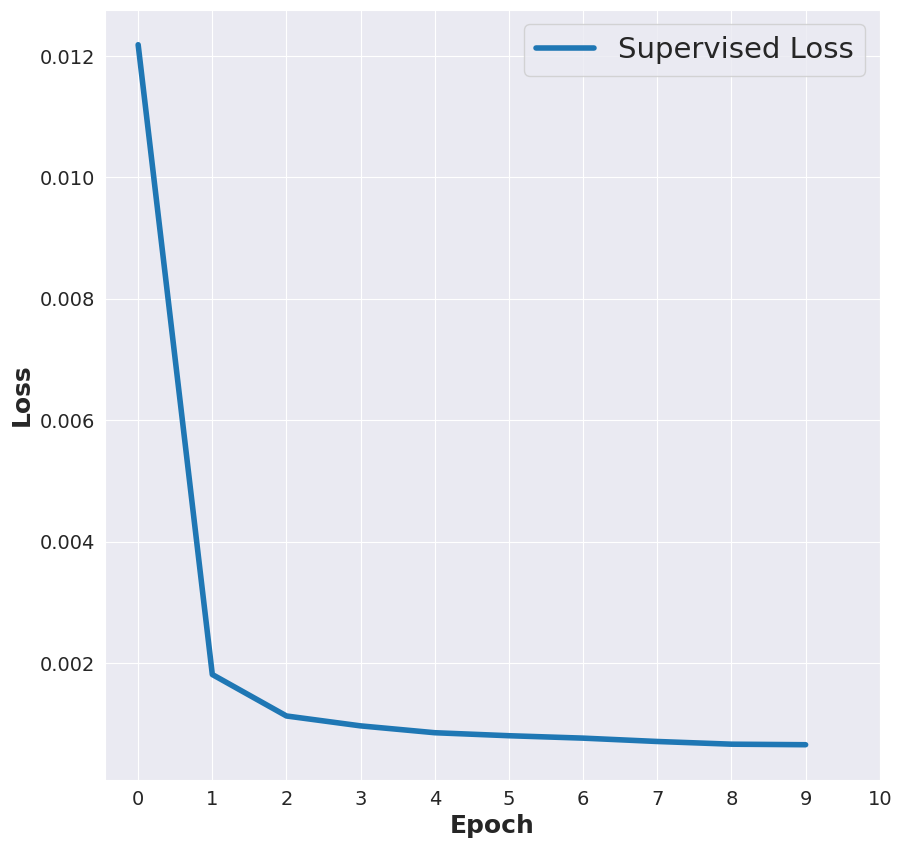

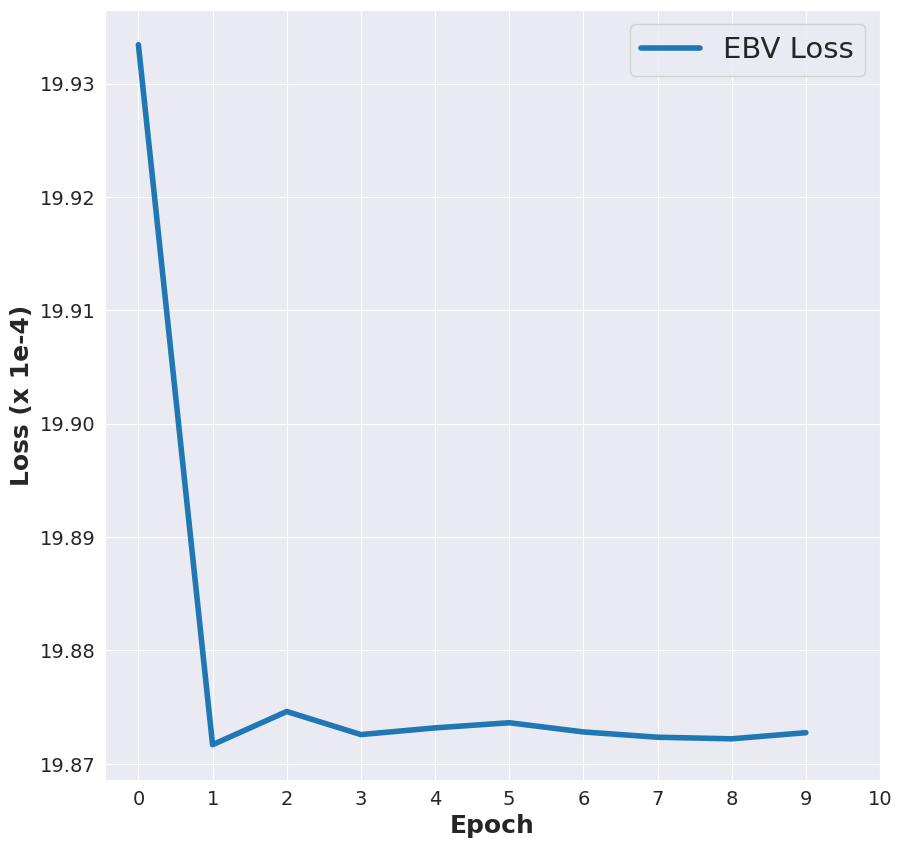

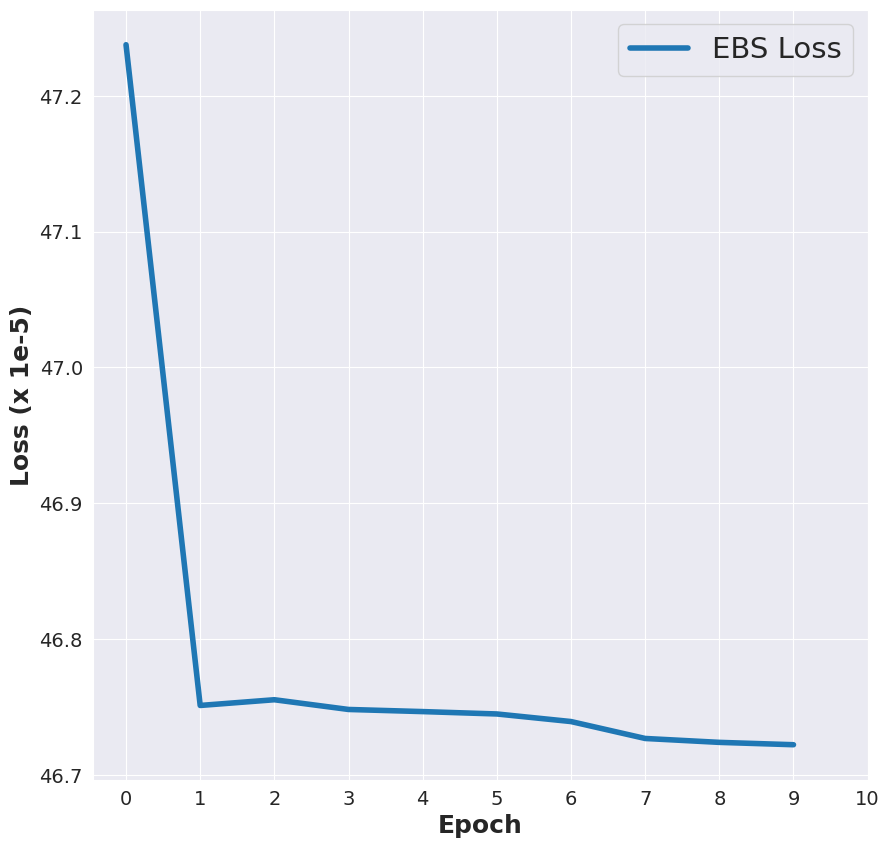

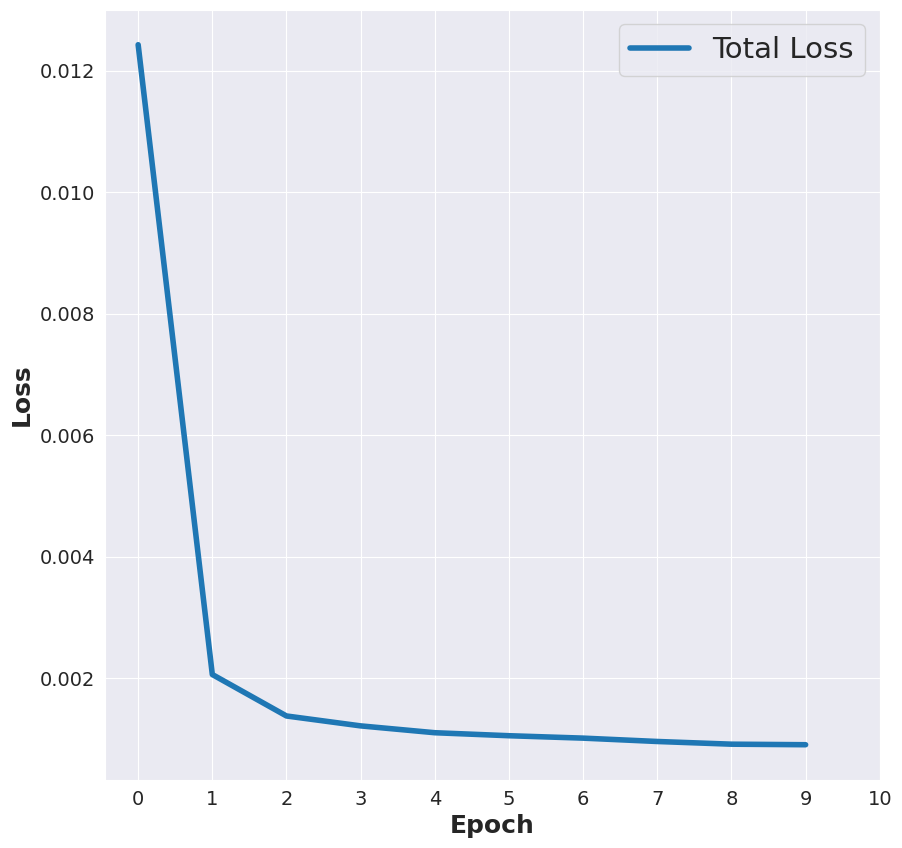

In [31]:
# loss_stats = {
#     'train': [],
#     'train regtms': [],
#     'train ebv': [],
#     'train ebs': []
#     # "val": []
# }

def plot_losses_seaborn_style(legend_title,losses_train,num_epochs,xlabel_title,ylabel_title):
    # legend_title: reqd title of legend
    # losses_train: list containing losses
    # num_epochs: #epochs reqd in x-axis
    # Plot the training losses Graph and save it
    fig = plt.figure(figsize=(10, 10))
    sns.set_style('darkgrid')
    plt.plot(losses_train,linewidth=4)
    plt.xticks(np.arange(0, num_epochs+1, 1))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel_title, fontsize=18, fontweight='bold')
    plt.ylabel(ylabel_title, fontsize=18,fontweight='bold')
    plt.legend([legend_title], prop={'size': 21})

    # plt.savefig(opdir1+'/losses.png')
    # plt.close()

    # # Store model and optimizer files
    # np.savez(opdir1+'/lossesfile', np.array(losses_train))

plot_losses_seaborn_style('Supervised Loss',loss_stats['train regtms'],EPOCHS,'Epoch','Loss')
plot_losses_seaborn_style('EBV Loss',[i * 1e4 for i in loss_stats['train ebv']],EPOCHS,'Epoch','Loss (x 1e-4)')
plot_losses_seaborn_style('EBS Loss',[i * 1e5 for i in loss_stats['train ebs']],EPOCHS,'Epoch','Loss (x 1e-5)')

plot_losses_seaborn_style('Total Loss',loss_stats['train'],EPOCHS,'Epoch','Loss')

In [32]:
## visualization of data format
samplefile='905_1220_1250_750.csv'
df_dummy=filepath2df(dirpath+samplefile)
df_dummy.head(3)

,timestep,firing_rates,walk_interval,setpoints,flowpattern,q_enthalpy,tG_gaszone,tS_furnace,tS_obstacle,w_flux_furnace,...,extinctioncoeff_k,gasvolumes_Vi,QfuelQa_sum,surfareas_Ai,emissivity_epsi,convection_flux_qconvi,firing_rates_next,tG_gaszone_prev,tS_furnace_prev,tS_obstacle_prev
0,1000035.0,"[0.162, 0.9, 0.689]",750,"[905.0, 1220.0, 1250.0]","[0.27214, 0.00037, 0.0, 0.0, 0.15124, 0.00502,...","[325971.875, 6805.781, 16632.312, 20740.859, 2...","[1238.396, 655.898, 669.693, 720.935, 783.621,...","[899.66, 696.459, 676.871, 707.375, 759.241, 8...","[282.33, 198.022, 230.603, 267.441, 244.599, 2...","[1227.219, 61.728, 44.997, 77.785, 123.674, 26...",...,"[0.035, 0.178, 0.625, 0.768, 25.748, 25.891]","[0.61, 0.581, 0.458, 0.458, 0.447, 0.681, 0.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.325, 0.312, 0.256, 0.256, 0.251, 0.388, 0.4...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[1227.219, 61.728, 44.997, 77.785, 123.674, 26...","[0.176, 0.9, 0.697]","[1230.741, 654.484, 668.378, 719.49, 782.103, ...","[898.918, 696.524, 676.938, 707.417, 759.248, ...","[272.753, 190.658, 221.352, 256.904, 235.417, ..."
1,1000050.0,"[0.176, 0.9, 0.697]",750,"[905.0, 1220.0, 1250.0]","[0.27379, 0.00031, 0.0, 0.0, 0.15469, 0.00493,...","[331067.125, 6830.078, 16803.453, 20947.594, 2...","[1245.547, 657.297, 670.983, 722.349, 785.105,...","[900.576, 696.454, 676.84, 707.373, 759.285, 8...","[291.843, 205.389, 239.773, 277.841, 253.712, ...","[1470.822, 138.764, 84.222, 121.113, 176.747, ...",...,"[0.035, 0.178, 0.625, 0.768, 25.748, 25.891]","[0.61, 0.581, 0.458, 0.458, 0.447, 0.681, 0.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.325, 0.312, 0.256, 0.256, 0.251, 0.388, 0.4...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[1470.822, 138.764, 84.222, 121.113, 176.747, ...","[0.188, 0.9, 0.705]","[1238.396, 655.898, 669.693, 720.935, 783.621,...","[899.66, 696.459, 676.871, 707.375, 759.241, 8...","[282.33, 198.022, 230.603, 267.441, 244.599, 2..."
2,1000065.0,"[0.188, 0.9, 0.705]",750,"[905.0, 1220.0, 1250.0]","[0.27532, 0.00027, 0.0, 0.0, 0.15768, 0.00486,...","[335621.75, 6849.953, 16960.344, 21137.922, 24...","[1252.052, 658.657, 672.223, 723.702, 786.523,...","[901.643, 696.504, 676.845, 707.41, 759.375, 8...","[301.287, 212.751, 248.861, 288.102, 262.75, 2...","[1680.182, 211.778, 121.823, 162.165, 226.299,...",...,"[0.035, 0.178, 0.625, 0.768, 25.748, 25.891]","[0.61, 0.581, 0.458, 0.458, 0.447, 0.681, 0.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.325, 0.312, 0.256, 0.256, 0.251, 0.388, 0.4...","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[1680.182, 211.778, 121.823, 162.165, 226.299,...","[0.197, 0.9, 0.712]","[1245.547, 657.297, 670.983, 722.349, 785.105,...","[900.576, 696.454, 676.84, 707.373, 759.285, 8...","[291.843, 205.389, 239.773, 277.841, 253.712, ..."


In [33]:
df_dummy.columns

Index(['timestep', 'firing_rates', 'walk_interval', 'setpoints', 'flowpattern',
       'q_enthalpy', 'tG_gaszone', 'tS_furnace', 'tS_obstacle',
       'w_flux_furnace', 'w_flux_obstacle', 'nodetmp_1d_furnace',
       'nodetmp_2d_obstacle', 'corrcoeff_b', 'Qconvi', 'extinctioncoeff_k',
       'gasvolumes_Vi', 'QfuelQa_sum', 'surfareas_Ai', 'emissivity_epsi',
       'convection_flux_qconvi', 'firing_rates_next', 'tG_gaszone_prev',
       'tS_furnace_prev', 'tS_obstacle_prev'],
      dtype='object')

In [34]:
### CODE for autoregressive evaluation of prediction on an entire furnace

def autoreg_eval_config(req_config,autoregeval=True): #autoregressive evaluation of a single config
    df=filepath2df(dirpath+req_config+'.csv')
    reqd_fields_X = ['firing_rates', 'walk_interval', 'setpoints',
                     'tG_gaszone_prev', 'tS_furnace_prev', 'tS_obstacle_prev' ,
                 ]
    reqd_fields_y = ['tG_gaszone','tS_furnace','tS_obstacle','firing_rates_next']
    X_cfg,y_cfg,ind_ranges_X_cfg,ind_ranges_y_cfg = df_to_Xy(df,reqd_fields_X, reqd_fields_y)
    # return X_cfg,y_cfg,ind_ranges_X_cfg,ind_ranges_y_cfg

    print(X_cfg.shape,y_cfg.shape)
    print(ind_ranges_X_cfg,sum(ind_ranges_X_cfg))
    print(ind_ranges_y_cfg,sum(ind_ranges_y_cfg))

# print(y_cfg[[0],:])
    with torch.no_grad():
        model.eval()
        for sample_id in range(X_cfg.shape[0]):
            # print('sample_id: ',sample_id)
            if sample_id!=0:
                if autoregeval==True:
                    X_cfg_sample_np= np.hstack([next_firing_rates_np,X_cfg[[sample_id],3:7],prevtmps_np])  #take raw input sample
                else:
                    X_cfg_sample_np= X_cfg[[sample_id],:]  # use data directly, as in FRs provided externally (eg, via PID)
                # print('X_cfg_sample_np ',X_cfg_sample_np)
                X_cfg_sample_scaled = scaler_x.transform(X_cfg_sample_np) #scale the sample
                y_test_pred = model(get_torch_float(X_cfg_sample_scaled).to(device)) #convert to tensor and pass via model
                rescaled_preds_np=transformed2original_labels(y_test_pred.detach(),scaler_y)
                next_firing_rates_np, prevtmps_np=rescaled_preds_np[[0],-3:],rescaled_preds_np[[0],:202]
                ytst_pred_mat=torch.cat((ytst_pred_mat, y_test_pred), 0)
            else:
                X_cfg_sample_np=X_cfg[[sample_id],:] #take raw, unscaled input sample
                # print('X_cfg_sample_np ',X_cfg_sample_np)
                X_cfg_sample_scaled = scaler_x.transform(X_cfg_sample_np) #scale the sample
                y_test_pred = model(get_torch_float(X_cfg_sample_scaled).to(device)) #convert to tensor and pass via model
                rescaled_preds_np=transformed2original_labels(y_test_pred.detach(),scaler_y)
                next_firing_rates_np, prevtmps_np=rescaled_preds_np[[0],-3:],rescaled_preds_np[[0],:202]
                ytst_pred_mat=y_test_pred
    ytst_pred_mat = ytst_pred_mat.numpy()

    print('Prediction on '+req_config+' data (autoregeval='+str(autoregeval)+'): ')
    print_metrics(y_cfg,transformed2original_labels(ytst_pred_mat,scaler_y),ind_ranges_y_cfg)

    # print('ytst_pred_mat:', ytst_pred_mat.shape)
    # print(transformed2original_labels(ytst_pred_mat,scaler_y))
    # print('y_cfg:', y_cfg.shape)
    # print(y_cfg)

In [35]:
alltestfiles_wo_extension=['925_1220_1250_750', '965_1220_1250_750', '995_1220_1250_750',
'955_1190_1250_750', '955_1230_1250_750',
'955_1220_1250_750', '955_1220_1280_750', '955_1220_1300_750',
'955_1220_1250_705', '955_1220_1250_765', '955_1220_1250_810']

# req_configs=['925_1220_1250_750','965_1220_1250_750','995_1220_1250_750']
req_configs=alltestfiles_wo_extension

for req_config in req_configs:
    autoreg_eval_config(req_config)
#     autoreg_eval_config(req_config,autoregeval=False)

(1498, 209) (1498, 205)
[3, 1, 3, 24, 76, 102] 209
[24, 76, 102, 3] 205
Prediction on 925_1220_1250_750 data (autoregeval=True): 
RMSE--[tG, tS_fur, tS_obs]-- [13.48, 8.394, 23.989]
MSE--[tG, tS_fur, tS_obs]-- [302.186, 83.149, 2292.921]
MAE--[tG, tS_fur, tS_obs]-- [11.544, 7.671, 19.669]
MAPE--[fr_next]-- 22.944
(1498, 209) (1498, 205)
[3, 1, 3, 24, 76, 102] 209
[24, 76, 102, 3] 205
Prediction on 965_1220_1250_750 data (autoregeval=True): 
RMSE--[tG, tS_fur, tS_obs]-- [21.268, 22.528, 34.541]
MSE--[tG, tS_fur, tS_obs]-- [619.207, 512.773, 1881.76]
MAE--[tG, tS_fur, tS_obs]-- [18.753, 21.876, 30.571]
MAPE--[fr_next]-- 69.176
(1498, 209) (1498, 205)
[3, 1, 3, 24, 76, 102] 209
[24, 76, 102, 3] 205
Prediction on 995_1220_1250_750 data (autoregeval=True): 
RMSE--[tG, tS_fur, tS_obs]-- [31.113, 32.137, 43.981]
MSE--[tG, tS_fur, tS_obs]-- [1184.696, 1217.876, 3652.926]
MAE--[tG, tS_fur, tS_obs]-- [28.678, 31.777, 38.96]
MAPE--[fr_next]-- 25.534
(1498, 209) (1498, 205)
[3, 1, 3, 24, 76, 102] 